In [3]:
from skimage import transform
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import glob
import torch
import pydicom
from numpy import random
import matplotlib.pyplot as plt
import numpy as np
import csv
import pathlib
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.utils.model_zoo as model_zoo
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import cv2

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [2]:
image_base_path = "D:/CT_master/CBIS-DDSM_Dataset/train/"
test_image_base_path = "D:/CT_master/CBIS-DDSM_Dataset/test/"

raw_csv_path = "annotation/calc_case_description_train_set.csv"
test_raw_csv_path = "annotation/calc_case_description_test_set.csv"

In [4]:
with open(raw_csv_path, 'r') as f:
    d_reader = csv.DictReader(f)
    for row in d_reader:
        print(row)

OrderedDict([('patient_id', 'P_00007'), ('breast density', '4'), ('left or right breast', 'LEFT'), ('image view', 'CC'), ('abnormality id', '1'), ('abnormality type', 'calcification'), ('calc type', 'PLEOMORPHIC'), ('calc distribution', 'LINEAR'), ('assessment', '4'), ('pathology', 'BENIGN'), ('subtlety', '4'), ('image file path', 'Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.201322325113694962619881476352450072222/1.3.6.1.4.1.9590.100.1.2.228699627313487111012474405462022068297/000000.dcm'), ('cropped image file path', 'Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.241202057913673145232234613012384759880/1.3.6.1.4.1.9590.100.1.2.314135871111943890422150247820137952041/000001.dcm\n'), ('ROI mask file path', 'Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.241202057913673145232234613012384759880/1.3.6.1.4.1.9590.100.1.2.314135871111943890422150247820137952041/000000.dcm')])
OrderedDict([('patient_id', 'P_00007'), ('breast density', '4'), ('left or right bre

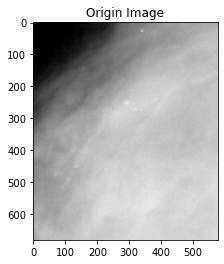

size:392937
min:0
max:65535
mean:42820.615373456814


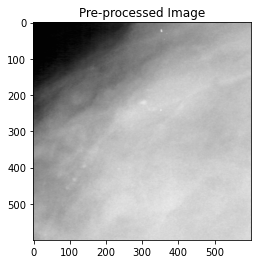

size:360000
min:-0.008826052770018578
max:1.0077944993972778
mean:0.6534014940261841


In [21]:
with open(raw_csv_path, newline='') as csvfile:
            rows = csv.DictReader(csvfile)
            for row in rows:
                dp = row['cropped image file path']
                dp = dp.split("/")
                # r=root, d=directories, f = files
                for r, d, f in os.walk(os.path.join(image_base_path, dp[0])):
                    for file in f:
                        if '00.dcm' in file:
                            image = pydicom.dcmread(os.path.join(r, file)).pixel_array
                            plt.imshow(image , cmap = 'gray'), plt.title('Origin Image')
                            plt.show()
                            print('size:{size}'.format(size = image.size))
                            print('min:{min}'.format(min = image.min()))
                            print('max:{max}'.format(max = image.max()))
                            print('mean:{mean}'.format(mean = image.mean()))
                            image = (image-image.min())/(image.max()-image.min()).astype(np.float32)
                            image = cv2.resize(np.array(image), (600, 600), interpolation=cv2.INTER_CUBIC)
                            plt.imshow(image , cmap = 'gray'), plt.title('Pre-processed Image')
                            plt.show()
                            print('size:{size}'.format(size = image.size))
                            print('min:{min}'.format(min = image.min()))
                            print('max:{max}'.format(max = image.max()))
                            print('mean:{mean}'.format(mean = image.mean()))
                            
                break;
                            

In [6]:
def rotate(image, angle, center=None, scale=1.0):

    (h, w) = image.shape[:2]
 
    if center is None:
        center = (w / 2, h / 2)

    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))

    return rotated


In [7]:
class CBISDDSMDataset(Dataset):
    def __init__(self, csv_path, data_path, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        super(CBISDDSMDataset, self).__init__()
        with open(csv_path, newline='') as csvfile:
            rows = csv.DictReader(csvfile)
            img_names = []
            imgs = []
            pathology = []
            annotations = -1
            for row in rows:
                #ds = pydicom.filereader.dcmread(os.path.join(image_base_path,row['image file path']))
                dp = row['cropped image file path']
                dp = dp.split("/")
                bm = row['pathology']
                bm = bm.split("_")
                if(bm[0] == "BENIGN"):
                    annotations = 0
                elif(bm[0] == "MALIGNANT"):
                    annotations = 1
                pathology.append(annotations)
                

                # r=root, d=directories, f = files
                for r, d, f in os.walk(os.path.join(data_path, dp[0])):
                    for file in f:
                        if '00.dcm' in file:
                            image = pydicom.dcmread(os.path.join(r, file)).pixel_array
                            image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
                            image = (image-image.mean())/(image.max()-image.min()).astype(np.float32)
                            image = cv2.resize(np.array(image), (600, 600), interpolation=cv2.INTER_CUBIC)
                            if(annotations == 1):
                                image_rot_90 = rotate(image,90)
                                imgs.append(image_rot_90)
                                pathology.append(annotations)
                                image_rot_180 = rotate(image,180)
                                imgs.append(image_rot_180)
                                pathology.append(annotations)
                                image_rot_270 = rotate(image,270)
                                imgs.append(image_rot_270)
                                pathology.append(annotations)
                            imgs.append(image)
               
            self.imgs = imgs   
            self.pathology = pathology
            self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        sample_pathology = self.pathology[idx]
        sample_img = self.imgs[idx]

        return (sample_img, sample_pathology)

In [8]:
CT_dataset = CBISDDSMDataset( raw_csv_path, image_base_path) 

In [9]:
CT_dataset_test = CBISDDSMDataset( test_raw_csv_path, test_image_base_path) 

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [11]:
dataloaders = DataLoader(dataset=CT_dataset,
                                    batch_size = 4,
                                     num_workers=0,
                                    shuffle = True)
testdataloader = DataLoader(dataset=CT_dataset_test,
                                    batch_size = 4,
                                     num_workers=0,
                                    shuffle = True)

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    batch = 4

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        running_loss = 0.0
        running_corrects = 0

        # train data
        # Iterate over data
        for inputs, labels in dataloaders:
            inputs = inputs.to(device=device, dtype=torch.float32)
            labels = labels.to(device=device, dtype=torch.int64)
            inputs = inputs.permute(0,3,1,2)
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward
            outputs = model(inputs)
            #outputs.aux_logits=False  #inception
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)                            
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()
        
        epoch_loss = running_loss / (len(dataloaders)*batch)
        epoch_acc = running_corrects.double() / (len(dataloaders)*batch)

        
        running_loss = 0.0
        running_corrects = 0
        tp = 0.0
        fp = 0.0
        fn = 0.0
        tn = 0.0
        
        # test data
        # Iterate over data
        
        for inputs, labels in testdataloader:
            inputs = inputs.to(device=device, dtype=torch.float32)
            labels = labels.to(device=device, dtype=torch.int64)
            inputs = inputs.permute(0,3,1,2)
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward
            outputs = model(inputs)
            #outputs.aux_logits=False
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # statistics
            running_loss += loss.item() * inputs.size(0)                            
            running_corrects += torch.sum(preds == labels.data)
            tp += (labels.data * preds).sum(dim=0).to(torch.float32)
            tn += ((1 - labels.data) * (1 - preds)).sum(dim=0).to(torch.float32)
            fp += ((1 - labels.data) * preds).sum(dim=0).to(torch.float32)
            fn += (labels.data * (1 - preds)).sum(dim=0).to(torch.float32)

        epoch_loss = running_loss / (len(testdataloader)*batch)
        epoch_acc = running_corrects.double() / (len(testdataloader)*batch)
        Recall = tp / (tp + fn)
        Precision = tp / (tp + fp)

        print('test Loss: {:.4f} Acc: {:.4f}'.format(
            epoch_loss, epoch_acc))
        print('Recall: {:.4f} Precision: {:.4f}'.format(Recall,Precision))
        
        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
device = torch.device("cuda:0")

In [21]:
#model2 squeezenet
model = models.squeezenet1_1(pretrained=True)
print(model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [20]:
torch.cuda.empty_cache()

In [22]:
model.fc = nn.Linear(512, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.00005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# step size could be
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
test Loss: 0.3090 Acc: 0.8296
Recall: 0.7810 Precision: 0.9853
Epoch 1/4
----------
test Loss: 0.3084 Acc: 0.8198
Recall: 0.7616 Precision: 0.9924
Epoch 2/4
----------
test Loss: 0.2897 Acc: 0.8282
Recall: 0.8178 Precision: 0.9420
Epoch 3/4
----------
test Loss: 0.2870 Acc: 0.8212
Recall: 0.7713 Precision: 0.9827
Epoch 4/4
----------
test Loss: 0.2804 Acc: 0.8408
Recall: 0.8585 Precision: 0.9210


In [28]:
#model1 resnet18
model = models.resnet18(pretrained=True)

In [29]:
"""
# freeze
for param in shufflenet.parameters():
    param.requires_grad = False
"""

model.fc = nn.Linear(512, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.00005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# step size could be
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
test Loss: 0.3448 Acc: 0.8128
Recall: 0.8353 Precision: 0.9036
Epoch 1/4
----------
test Loss: 0.3214 Acc: 0.8352
Recall: 0.8140 Precision: 0.9567
Epoch 2/4
----------
test Loss: 0.2990 Acc: 0.8478
Recall: 0.8779 Precision: 0.9133
Epoch 3/4
----------
test Loss: 0.2872 Acc: 0.8464
Recall: 0.8837 Precision: 0.9066
Epoch 4/4
----------
test Loss: 0.3198 Acc: 0.8338
Recall: 0.8857 Precision: 0.8891
